In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Import the data and take a quick peak at it
df = pd.read_csv("../data/CTA_Ridership_Cleaned.csv")
df.head()

,Unnamed: 0,service_date,day_type,bus,rail_boardings,total_rides,year,month,weekday
0,1195,2001-01-01,U,297192,126455,423647,2001,1,Monday
1,7906,2001-01-02,W,780827,501952,1282779,2001,1,Tuesday
2,6604,2001-01-03,W,824923,536432,1361355,2001,1,Wednesday
3,6528,2001-01-04,W,870021,550011,1420032,2001,1,Thursday
4,5067,2001-01-05,W,890426,557917,1448343,2001,1,Friday


In [16]:
df["service_date"] = pd.to_datetime(df["service_date"])
df['day'] = df["service_date"].dt.day
df["weekday"] = df["service_date"].dt.weekday
df["dayofyear"] = df["service_date"].dt.dayofyear
df["prev_day_rides"] = df["total_rides"].shift(1)
df = df.dropna()

In [23]:
# Define our X and our y so we can begin model training
X = df[["dayofyear", "year", "month", "day", "weekday", "prev_day_rides"]]
y = df["total_rides"]

# Create our test train and split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 42)

# Now we can import our model, from what we say in EDA our data is not linear meaning
# we should use Random Forest and import MAE to eval the model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.0f} Rides")
print(f"R2 Score: {r2:.2f}")

MAE: 81,419 Rides
R2 Score: 0.62


As we can see we obtained an R2 score of 0.62 which is decent, but we can do better. Lets do some feature engineering to try to get a better score. Lets see some feature importance to see whats working to this point

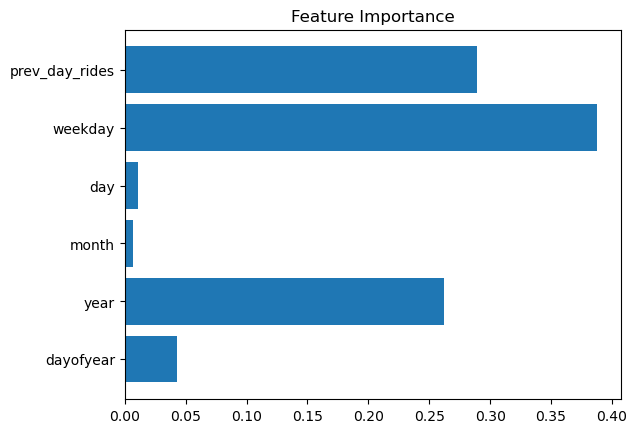

In [30]:
# Let's check out some feature importance
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.title("Feature Importance")
plt.show()


## Feature Engineering Strat
To improve model performance, I added:
- "is_weekend": 1 if Saturday/Sunday
- "is_holiday": 1 if day type was U (holiday)
- "rolling_avg_7" and "rolling_avg_30": average rides in past 7 or 30 days

Altogether what these features provide is trend information to help the model gain better insights on recent trends

In [27]:
# Take some data about the day time
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)
df["is_holiday"] = df["day_type"].isin(["U"]).astype(int)

# Rolling averages data
df["rolling_avg_7"] = df["total_rides"].rolling(7).mean()
df["rolling_avg_30"] = df["total_rides"].rolling(30).mean()
df = df.dropna()

# Take another peek at our new and (hopefully) improved dataset
df.head()

,Unnamed: 0,service_date,day_type,bus,rail_boardings,total_rides,year,month,weekday,dayofyear,prev_day_rides,day,is_weekend,is_holiday,rolling_avg_7,rolling_avg_30
91,8595,2001-04-02,W,1023629,611098,1634727,2001,4,0,92,610433.0,2,0,0,1.367803e+06,1.340870e+06
92,6692,2001-04-03,W,1057275,613993,1671268,2001,4,1,93,1634727.0,3,0,0,1.375296e+06,1.377770e+06
93,5704,2001-04-04,W,1047634,625348,1672982,2001,4,2,94,1671268.0,4,0,0,1.384336e+06,1.386441e+06
94,8395,2001-04-05,W,973118,606535,1579653,2001,4,3,95,1672982.0,5,0,0,1.377840e+06,1.385193e+06
95,6160,2001-04-06,W,1015046,611352,1626398,2001,4,4,96,1579653.0,6,0,0,1.386091e+06,1.384569e+06


In [37]:
# Time to retrain our model and try again with our new columns

X = df[["year", "month", "weekday", "dayofyear", "prev_day_rides", "day", "is_weekend",
        "is_holiday", "rolling_avg_7", "rolling_avg_30"]]

y = df["total_rides"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 42)

model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.0f} Rides")
print(f"R2 Score: {r2:.2f}")

MAE: 68,619 Rides
R2 Score: 0.82


Our model improved a lot more, now with an R2 Score of 0.82, lets see how our new features impacted the model

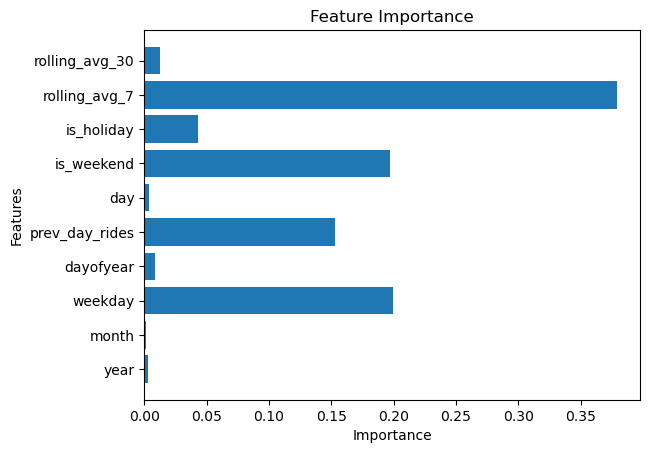

In [41]:
importance = model.feature_importances_
features = X.columns
plt.barh(features, importance)
plt.title("Feature Importance")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

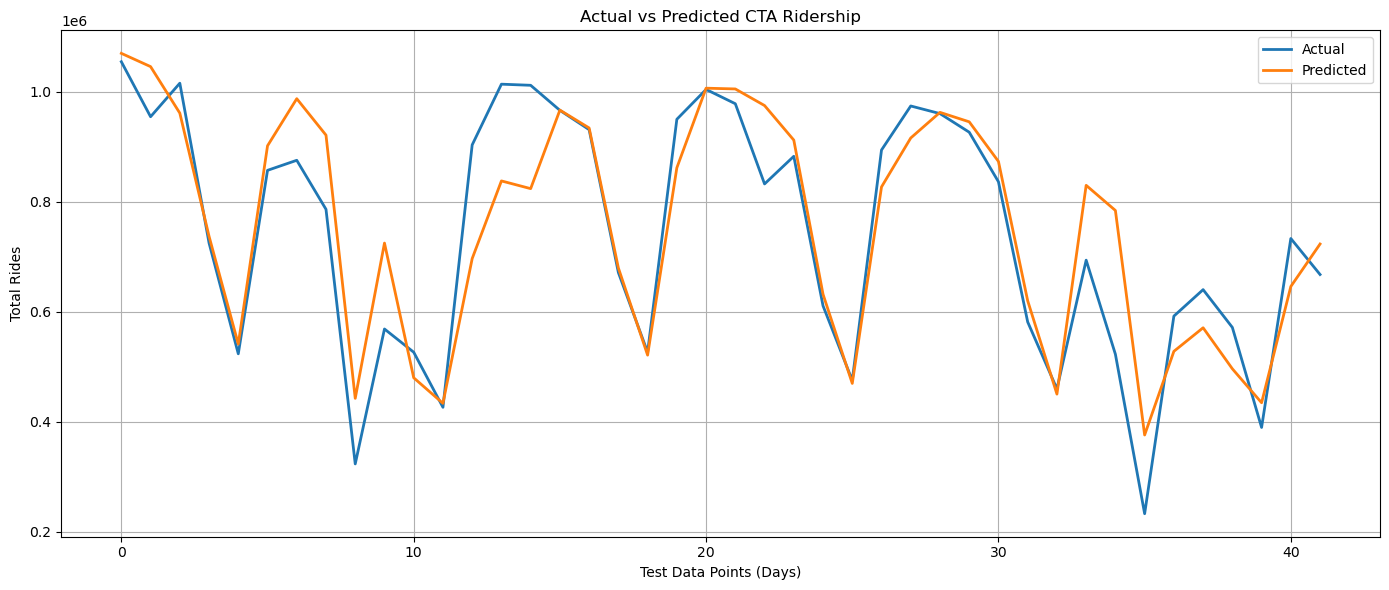

In [43]:
# What we can also do is see the comparison between predicted and actual model values

plt.figure(figsize = (14,6))
plt.plot(y_test.values, label = "Actual", linewidth = 2)
plt.plot(y_pred, label = "Predicted", linewidth = 2)
plt.title("Actual vs Predicted CTA Ridership")
plt.xlabel("Test Data Points (Days)")
plt.ylabel("Total Rides")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()